In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the dataset
file_path = '../cleaner/cleaned_ads_dimension.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
data.head()

,ad_id,delivery_country,punish_num,avg_ad_revenue,baseline_st
0,1747578422390810,US,1,4795.250,1.78
1,1758543228094480,SA,1,1063.767,1.67
2,1738303151826990,AU,2,5.365,1.84
3,1738303920938010,NZ,2,5.365,1.58
4,1738304016410620,NZ,2,5.365,1.58


In [2]:
# Convert to max-max problem
data["punish_num"] *= -1

# Step 1: Identifying the Nadir and Utopia points
utopia_point = [data['avg_ad_revenue'].max(), data['punish_num'].max()]
nadir_point = [data['avg_ad_revenue'].min(), data['punish_num'].min()]

# Step 2: Normalizing the objective values
data['normalized_avg_ad_revenue'] = (data['avg_ad_revenue'] - utopia_point[0]) / (nadir_point[0] - utopia_point[0])
data['normalized_punish_num'] = (data['punish_num'] - utopia_point[1]) / (nadir_point[1] - utopia_point[1])

# Step 3: Recalculating the distance to Utopia point using the normalized values
data['normalized_distance_to_utopia'] = ((data['normalized_avg_ad_revenue'] - 0)**2 + (data['normalized_punish_num'] - 0)**2)**0.5

# Displaying the first few rows of the dataset with the new normalized columns
data.head()


,ad_id,delivery_country,punish_num,avg_ad_revenue,baseline_st,normalized_avg_ad_revenue,normalized_punish_num,normalized_distance_to_utopia
0,1747578422390810,US,-1,4795.250,1.78,0.720304,0.0625,0.723010
1,1758543228094480,SA,-1,1063.767,1.67,0.937953,0.0625,0.940033
2,1738303151826990,AU,-2,5.365,1.84,0.999687,0.1250,1.007472
3,1738303920938010,NZ,-2,5.365,1.58,0.999687,0.1250,1.007472
4,1738304016410620,NZ,-2,5.365,1.58,0.999687,0.1250,1.007472


In [3]:
# Step 5: Ranking the Records Based on Priority
data['priority_rank'] = data.groupby('delivery_country')['normalized_distance_to_utopia'].rank(method='first')

# Step 6: Generating the Queues
queues = data.sort_values(by=['delivery_country', 'priority_rank']).groupby('delivery_country')['ad_id'].apply(list)

# Displaying the first few queues
queues.head()


delivery_country
AE    [1772824938410000, 1771639952060430, 177175490...
AR    [1767234953622530, 1769982368863240, 177231827...
AT    [1773293685750830, 1773293685750830, 177320547...
AU    [1773563867768910, 1765107022556160, 176510702...
BE    [1773205472709660, 1758841989024770, 177356037...
Name: ad_id, dtype: object

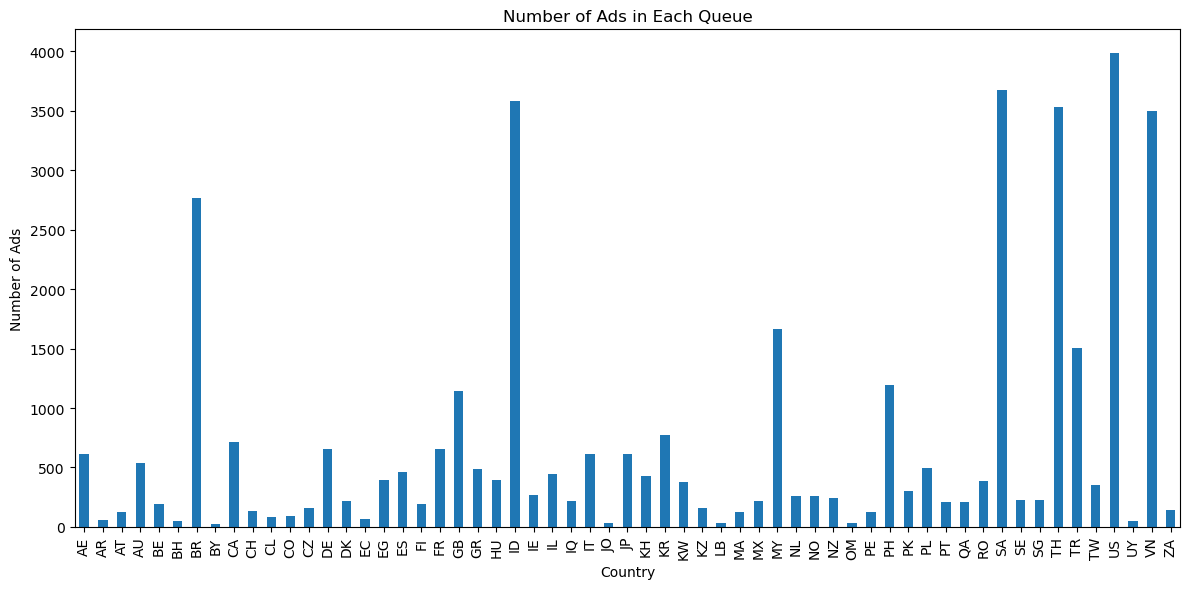

In [7]:
# Counting the number of ads in each queue
queue_lengths = queues.apply(len)

# Creating a bar plot to visualize the number of ads in each queue
plt.figure(figsize=(12, 6))
queue_lengths.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Ads')
plt.title('Number of Ads in Each Queue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
# Load the moderator data
mod_data = pd.read_csv('../cleaner/cleaned_moderator_dimension.csv')
# Renaming the accuracy column to remove extra whitespaces
mod_data.rename(columns={'  accuracy  ': 'accuracy'}, inplace=True)
# Display the first few rows of the moderator data to understand its structure
mod_data.head()

,moderator,Productivity,Utilisation %,handling time,accuracy,AE,AR,AT,AU,BE,...,TH,TN,TR,TW,UA,US,UY,UZ,VN,ZA
0,1689841547143170,286.217674,0.812403,123549,-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1686755036370945,174.560000,0.704833,25547,0.959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1741913197768705,334.376000,0.819167,50794,1.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1743415203890193,452.277500,0.775474,89626,0.941,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1710346282427393,612.312500,0.843229,98066,0.887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Cleaning the accuracy column and converting it to a numeric type
mod_data['accuracy'] = pd.to_numeric(mod_data['accuracy'], errors='coerce')

# Calculating the score and daily capacity for each moderator
mod_data['score'] = (mod_data['Productivity'] * mod_data['Utilisation %'] * mod_data['accuracy']) / mod_data['handling time']
mod_data['daily_capacity'] = (mod_data['Productivity'] * mod_data['Utilisation %']).astype(int)

# Displaying the first few rows of the data with the calculated scores and daily capacity
mod_data.head()

,moderator,Productivity,Utilisation %,handling time,accuracy,AE,AR,AT,AU,BE,...,TR,TW,UA,US,UY,UZ,VN,ZA,score,daily_capacity
0,1689841547143170,286.217674,0.812403,123549,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,232
1,1686755036370945,174.560000,0.704833,25547,0.959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004619,123
2,1741913197768705,334.376000,0.819167,50794,1.000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.005393,273
3,1743415203890193,452.277500,0.775474,89626,0.941,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0.003682,350
4,1710346282427393,612.312500,0.843229,98066,0.887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004670,516


In [27]:
def assign_ads_to_mods(queue, mod_data):
    # Step 1: Initialize an empty dictionary to store the assignments
    assignments = {}

    # Step 2: Iterate through the ad data series country-wise
    for country, ads in queue.iteritems():

        # Step 3: Identify the moderators who oversee the respective country and have valid scores
        eligible_mods = mod_data[(mod_data[country] == 1) & mod_data['score'].notna()].copy()
        
        # If there are no eligible mods for a country, continue to the next country
        if eligible_mods.empty:
            continue
        
        # Sort the eligible moderators based on their scores in descending order
        eligible_mods.sort_values(by='score', ascending=False, inplace=True)
        
        # Step 5: Assign ads to moderators based on their scores and daily capacity
        ad_queue = list(ads)
        for _, mod in eligible_mods.iterrows():
            if not ad_queue:
                break
                
            assigned_ads = []
            for _ in range(min(int(mod['daily_capacity']), len(ad_queue))):
                assigned_ads.append(ad_queue.pop(0))
            
            # Update the assignments dictionary
            if assigned_ads:
                assignments[mod['moderator']] = assigned_ads
    
    # Step 6: Return the dictionary with the assignments
    return assignments

/var/folders/9j/1bsg37c11p55zns33dj9tr3c0000gn/T/ipykernel_3610/1028226348.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for country, ads in queue.iteritems():


{1958955.0: [1772824938410000,
  1771639952060430,
  1771754906530830,
  1772391988888610,
  1771680101787690,
  1760366691144720,
  1773439605252090,
  1772468246696960,
  1772946182003740,
  1772628620777500,
  1771387678152750,
  1771388794475530,
  1772318695395360,
  1773212785233920,
  1773464609528830,
  1773482289162240,
  1766314378324030,
  1763070519096330,
  1772461683919900,
  1765500335365170,
  1773299655317520,
  1765710157502460,
  1773522284887070,
  1773522318441500,
  1770501750751240,
  1770729324566570,
  1770729324566570,
  1771281787754530,
  1771281787754530,
  1771116365845520,
  1771210452412430,
  1771301192620050,
  1773538912813100,
  1773534469479420,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1770540310140920,
  1772956737568770,
  1773404180712450,
  1773496827184120,
  1767100160054300,
  1767100264605710,
  1768033175956480,
  1768656371969020,
  1773194793107550,
  1773505

In [31]:
# Running the function with the ad data series and moderator data
assignments = assign_ads_to_mods(queues, mod_data)

# Displaying the first assignments as an example output
dict(list(assignments.items())[:1])

/var/folders/9j/1bsg37c11p55zns33dj9tr3c0000gn/T/ipykernel_3610/1028226348.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for country, ads in queue.iteritems():


{1958955.0: [1772824938410000,
  1771639952060430,
  1771754906530830,
  1772391988888610,
  1771680101787690,
  1760366691144720,
  1773439605252090,
  1772468246696960,
  1772946182003740,
  1772628620777500,
  1771387678152750,
  1771388794475530,
  1772318695395360,
  1773212785233920,
  1773464609528830,
  1773482289162240,
  1766314378324030,
  1763070519096330,
  1772461683919900,
  1765500335365170,
  1773299655317520,
  1765710157502460,
  1773522284887070,
  1773522318441500,
  1770501750751240,
  1770729324566570,
  1770729324566570,
  1771281787754530,
  1771281787754530,
  1771116365845520,
  1771210452412430,
  1771301192620050,
  1773538912813100,
  1773534469479420,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1770540310140920,
  1772956737568770,
  1773404180712450,
  1773496827184120,
  1767100160054300,
  1767100264605710,
  1768033175956480,
  1768656371969020,
  1773194793107550,
  1773505

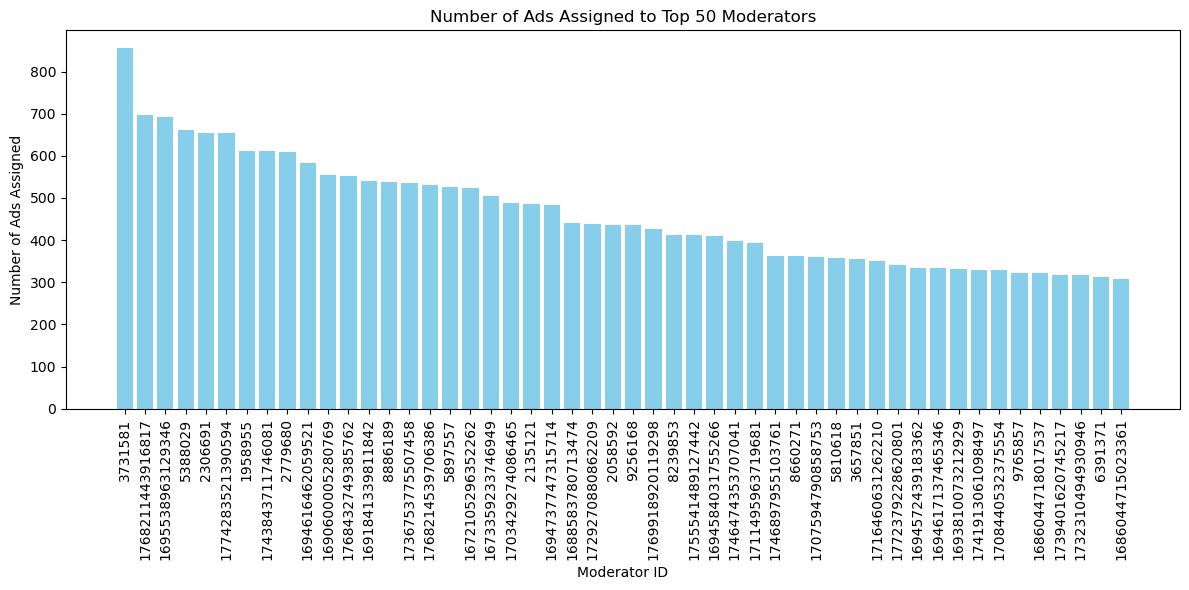

In [36]:
# Converting all moderator IDs to strings
mod_assignment_counts_str = {str(int(mod)): count for mod, count in mod_assignment_counts.items()}

# Sorting the dictionary by the number of ads assigned to each moderator in descending order and getting the top 50
sorted_mod_assignment_counts_str = {k: v for k, v in sorted(mod_assignment_counts_str.items(), key=lambda item: item[1], reverse=True)}
top_50_mods_str = list(sorted_mod_assignment_counts_str.keys())[:50]
top_50_assignment_counts_str = list(sorted_mod_assignment_counts_str.values())[:50]

# Creating a bar plot for the top 50 moderators
plt.figure(figsize=(12, 6))
plt.bar(top_50_mods_str, top_50_assignment_counts_str, color='skyblue')

# Adding titles and labels
plt.title('Number of Ads Assigned to Top 50 Moderators')
plt.xlabel('Moderator ID')
plt.ylabel('Number of Ads Assigned')
plt.xticks(rotation=90)

# Displaying the plot
plt.tight_layout()
plt.show()